In [48]:
# Imports
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import random

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

In [75]:
# Class of k-Nearest Neigbor Classifier


class kNN():
    def __init__(self, k = 3, exp = 2, normalise=False):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
        self.normalise = normalise
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
    
        if self.normalise:
            self.X_train = normalise(X_train)
            #self.Y_train = normalise(Y_train)
        else:
            self.X_train = X_train
        self.Y_train = Y_train
         
    def getDiscreteClassification(self, X_test):
    # predict-class k-NN method
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
    
        if self.normalise:
            X_test = normalise(X_test)
            
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    #########
    # PART B
    #########
    # Add  to  class  kNN  method  normalize  that  normalizes  the  input  attributes  of  the training data
    # X_train and test data X_test. We note that attribute normalization is important since all the attributes 
    # receive equal weights when instance distances are being computed. To implement method normalize you might
    # use method max of pandas.DataFrame since both X_train and X_test are pandas.DataFrame. 
    def normalise(X) -> pd.DataFrame:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
    
    #########
    # PART C
    #########
    # Computes for all the test instances in X_test the posterior class probabilities. This means that
    # the method computes for each row (instance) in X_test a row with probability of class 1, probability
    # of class 2, and probability of class N. Combine the rows of the posterior class probabilities in 
    # pandas.DataFrame object that will be the output of the method getClassProbs.
    def getClassProbs() -> pd.DataFrame:
        pass
    
    
    #########
    # PART D
    #########
    # Add to class kNN method getPrediction that computes for all the test instances in  X_test  regression
    # values  for  the  output  attribute.  This  means  that  the  method computes for each instance (row)
    # in X_test a regression value equal to the average of  y  values  in  Y_train  of  the  k-nearest  neighbors
    # of  the  instance  in  X_train. Combine  the  computed  regression  values  for  all  the  instances  in  
    # X_test  in pandas.DataFrame object that will be the output of the method getPrediction. 
    def getPrediction() -> pd.DataFrame:
        pass


In [69]:
def k_experiment(csv_file_name, normalise=False):
    ##################################################
    # Hold-out testing: Training and Test set creation
    ##################################################

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    # range for the values of parameter k for kNN

    k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

    trainAcc = np.zeros(len(k_range))
    testAcc = np.zeros(len(k_range))


    index = 0 
    for k  in  k_range:
        clf = kNN(k, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.getDiscreteClassification(X_train)
        Y_predTest = clf.getDiscreteClassification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1


    #########################################
    # Plot of training and test accuracies
    #########################################

    plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    
    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)

In [70]:
def exp_experiment(csv_file_name, normalise=False):
    ##################################################
    # Hold-out testing: Training and Test set creation
    ##################################################

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    # range for the values of parameter exp for kNN
    exp_range = [2,  100, 10000] 

    trainAcc = np.zeros(len(exp_range))
    testAcc = np.zeros(len(exp_range))

    index = 0 
    for exp  in  exp_range:
        clf = kNN(k = 3, exp = exp, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.getDiscreteClassification(X_train)
        Y_predTest = clf.getDiscreteClassification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1


    #########################################
    # Plot of training and test accuracies
    #########################################

    plt.plot(exp_range,trainAcc,'ro-',exp_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('exp')
    plt.ylabel('Accuracy')

    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)

Test  the  kNN  classifier  on  the  diabetis  and  glass  classification  data  sets  (see Appendix A) for the case when the data is not normalized and the case when the data is normalized. Indicate whether the training and  hold-out accuracy rates improve with normalization.  

For  testing  the  kNN  classifier  you  might  use  the  script  provided  in  the  Jupiter notebook.  The  script  provides  a  plot  with  training  and  hold-out  accuracy  rates  in function of parameter k of the kNN classifier. 

Test the kNN classifier on the glass classification data sets the data is normalized for different  values  of  the  exp  parameter  of  the  Minkowski  distance.  Indicate  whether the training and  hold-out accuracy rates changes due to exp. For this task you might use the second testing script provided in the Jupiter note.

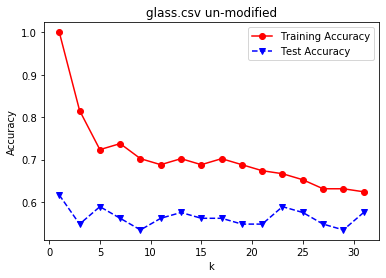

In [71]:
k_experiment('glass.csv', normalise=False)

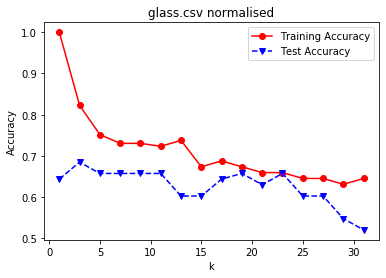

In [72]:
k_experiment('glass.csv', normalise=True)

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars


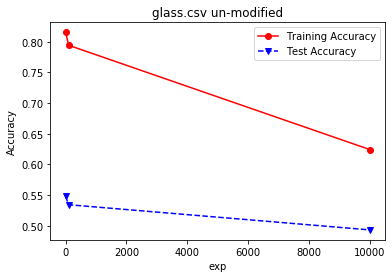

In [76]:
exp_experiment('glass.csv', normalise=False)

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars


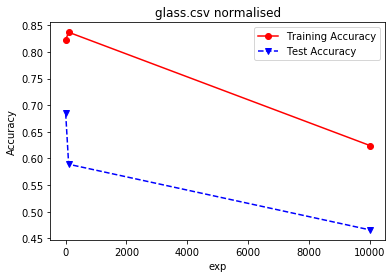

In [77]:
exp_experiment('glass.csv', normalise=True)

In [ ]:
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_absolute_error(y_true, y_pred)

In [ ]:
data = pd.read_csv('autoprice.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)
data.head()